## Multimodal RAG

Traditional RAG based question-answering system are limited to text data only, with the help of Gemini's multimodal LLMs we can build systems which understand both text and images.  
We are limiting ourself to a single PDF for now. The system will be able to answer from all text and images found in the PDF.

#### Detailed Flow  
1. Extract texts (Markdown format) and images from the PDF.
2. Generate caption for each of the image, and replace the images placeholder with their caption in extracted text.
3. Chunk the text into smaller segments.
4. Create vector database for the chunked text.
5. For the given user query retrieve top-k text chunks.
6. Call LLM to answer the user query based on the retrieved chunks.


#### This notebook will cover following Gen AI capabilities:

- Structured output/JSON mode/controlled generation
- Image understanding
- Embeddings
- Retrieval augmented generation (RAG)
- Vector search/vector store/vector database

#### Libraries/Frameworks Used:
- Google Genai
- ChromaDB
- pymupdf4llm
- llama_index

## Download sample PDFs and install packages
For demo we will use the popular research paper 'Scaling LLM Test-Time Compute Optimally can be More Effective than Scaling Model Parameters' available at https://arxiv.org/pdf/2408.03314

In [1]:
#Download sample pdf
!wget -O /kaggle/working/sample_pdf.pdf https://arxiv.org/pdf/2408.03314.pdf -q

#Install required packages 
!pip install pymupdf4llm chromadb llama-index -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.7/808.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.8 MB/s eta 0:00:

In [2]:
# Set GOOGLE_API_KEY in enviornment variable from kaggle secrets
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ['GOOGLE_API_KEY'] = user_secrets.get_secret("GOOGLE_API_KEY")

## Step 1: PDF to Text Conversion

In [3]:
# Using pymupdf4llm, as it give us the ability to extract both images and text in markdown
import pymupdf4llm
from IPython.display import Markdown

In [4]:
#Configure paths
class config:
    pdf_path = "sample_pdf.pdf" #Path of input PDF
    image_path = "./tmp" #Path to store extracted images

In [5]:
#Extract text and images into markdown format from PDF
md_text = pymupdf4llm.to_markdown(
    config.pdf_path, 
    write_images=True, 
    dpi=300, 
    image_format='png', 
    image_path = config.image_path, 
    force_text=False
)

In [6]:
#md_text is the Markdown formatted text of whole PDF.
#pymupdf4llm puts a placeholder like '![](./tmp/sample_pdf.pdf-1-0.png)' to point to an image in the Markdown output (see example below).
#If we chunk the text directly we wont be able to capture what is present in the image.
#So, we will use Gemini to create a description of image, and replace the placeholder with generated description.
md_text[4900:5100]

'of-N Weighted Compute Optimal|||||\n|||||||\n|||||||\n|||||||\n|||||||\n|||||||\n\n\n![](./tmp/sample_pdf.pdf-1-0.png)\n\n2 1 2 3 2 5 2 7 2 9\n\nGeneration Budget\n\n\nCompute Optimal Revisions\n\n2 [1] 2 [3] 2 [5] 2 '

## Step 2: Generate caption for each image and add to original markdown text

In [7]:
#Import Packages
import time
from google import genai
from google.genai import types
from tqdm import tqdm
import typing_extensions as typing
import re

def extract_image_patterns(text, base_path='./tmp'):
    '''
    Find all patterns like ![](./tmp/sample_pdf.pdf-1-0.png) from the text
    '''
    pattern = rf'!\[\]\({re.escape(base_path)}/[^)]+\)'
    return re.findall(pattern, text)

def extract_path(text, base_path='./tmp'):
    '''
    Extract filepath './tmp/sample_pdf.pdf-1-0.png' from text like ![](./tmp/sample_pdf.pdf-1-0.png)
    '''
    pattern = rf'!\[\]\(({re.escape(base_path)}/[^)]+)\)'
    matches = re.findall(pattern, text)
    return matches[0] if matches else None


#Defining output schema for a Structured output/JSON mode/controlled generation
class CaptionSchema(typing.TypedDict):
    caption: str


# Initialize client to access Gemini
client = genai.Client()

def caption_image(image_path, model_id='gemini-2.0-flash' ,max_retries=3):
    '''
    Read image_path, and call LLM model_id to generate a caption, with a structred output. Retry if the output is not properly formatted.
    '''
    for i in range(max_retries):
        try:
            #Read the image
            with open(image_path, 'rb') as f:
                img_bytes = f.read()

            #Call Gemini LLM to generate caption with a structured output JSON
            response = client.models.generate_content(
                model=model_id,
                contents=[
                  types.Part.from_bytes(
                    data=img_bytes,
                    mime_type='image/png',
                  ),
                  'Caption this image.'
                ],
                config=types.GenerateContentConfig(
                    temperature=0.01,
                    response_mime_type="application/json",
                    response_schema=CaptionSchema,
                ),
            )
            # Checks if the output has the key caption as defined in schema.
            if 'caption' in response.parsed:
                return response.parsed['caption']
        except:
            time.sleep(60)#Sleep for 60s because gemini API has a rate limit per minute
            pass
    print(f"Warning! Unable to generate caption for {image_path} after max_retries {max_retries}")
    return ""

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [8]:
# Generate captions of identified images
image_data = extract_image_patterns(md_text, config.image_path)
image_data = [{"md_text": i, "img_path": extract_path(i, config.image_path)} for i in image_data]
image_data = [{**i, **{"caption": caption_image(i["img_path"])}} for i in tqdm(image_data)]
image_data[0]

100%|██████████| 30/30 [01:44<00:00,  3.50s/it]


{'md_text': '![](./tmp/sample_pdf.pdf-1-0.png)',
 'img_path': './tmp/sample_pdf.pdf-1-0.png',
 'caption': 'The image shows a line graph comparing the performance of four different methods: Majority, ORM Best-of-N Weighted, PRM Best-of-N Weighted, and PRM Compute Optimal. The graph plots the performance of each method as a function of some variable, with each method represented by a different colored line. The PRM Compute Optimal method appears to have the best performance, followed by PRM Best-of-N Weighted, ORM Best-of-N Weighted, and finally Majority.'}

In [9]:
# Add captions to original markdown text
preprocessed_text = md_text

for i in image_data:
    preprocessed_text = preprocessed_text.replace(i['md_text'], f"![{i['caption']}]")

## Step 3: Chunk the preprocessed text

In [10]:
# Using Llamaindex SentenceSplitter to chunk text
from llama_index.core.text_splitter import SentenceSplitter

node_parser = SentenceSplitter(chunk_size=1024, chunk_overlap=128)

In [11]:
#Split text using the SentenceSplitter based node_parser
text_corpus = node_parser.split_text(preprocessed_text)

## Step 4: Create vector database of chunked text  
We will use chromadb to store embeddings inside an in-memory database

In [12]:
import chromadb
from chromadb.utils import embedding_functions

#Create InMemory database
chroma_client = chromadb.Client()

#Define the embedding model for chromadb, using "all-MiniLM-L6-v2" in our case
embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

#Create a collection which uses cosine similarity
collection = chroma_client.create_collection(
    name="MyRAG", 
    metadata={"hnsw:space": "cosine"}, 
    embedding_function=embedding_func
)

2025-04-19 17:54:46.285329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745085286.535698      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745085286.614992      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Add chunks and their unique id into chromadb

In [13]:
#Create a unique ID for each chunk using sha256
import hashlib

def generate_sha256(text):
    # Encode the text to bytes, then compute the SHA-256 hash
    sha_signature = hashlib.sha256(text.encode()).hexdigest()
    return sha_signature

#Store chunks and their ID into database
corpus = [{'id':generate_sha256(i),'text':i} for i in text_corpus]

collection.add(
    documents = [i['text'] for i in corpus],
    ids = [i['id'] for i in corpus]
)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

## Step 5: Retrieve Top-K similar chunks for the given user query

Lets craft a sample query based on an image

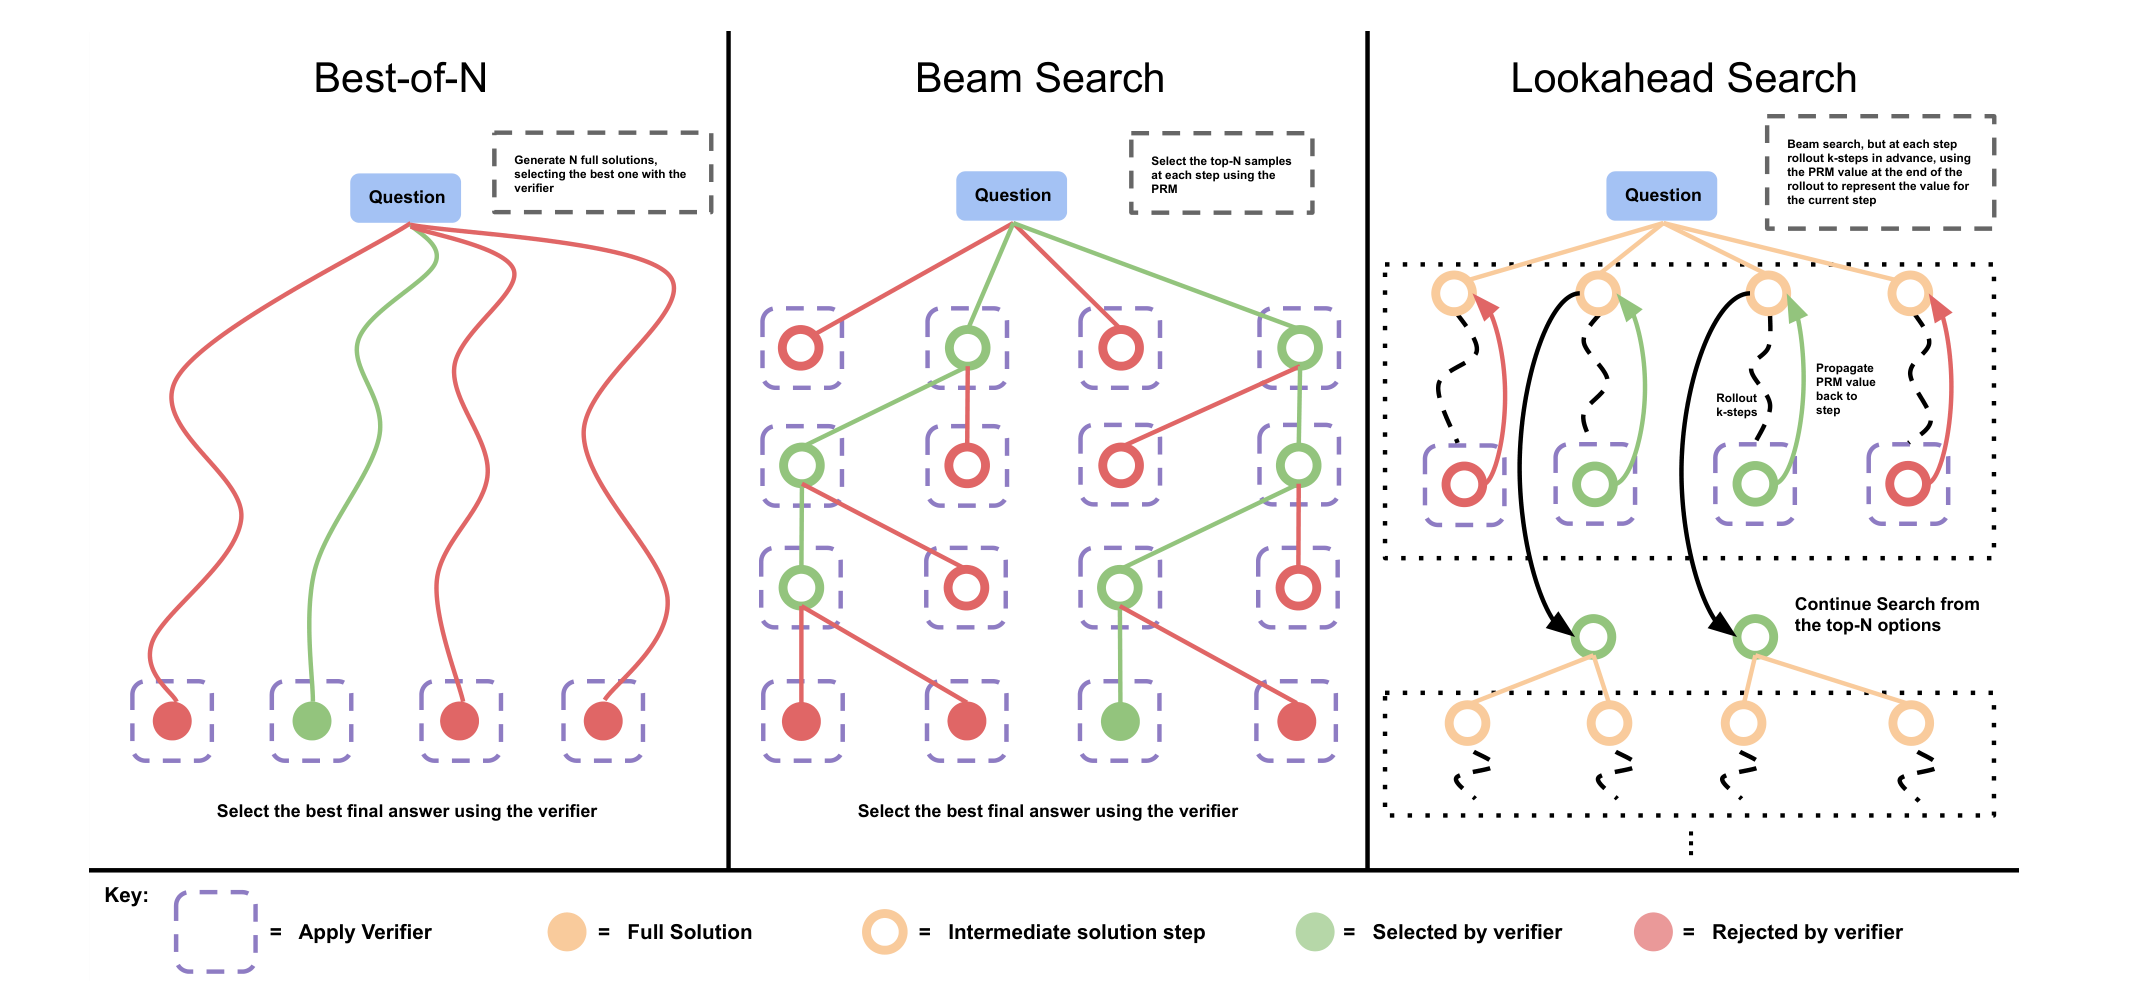

In [14]:
from IPython.display import Image, display

#Display sample image
display(Image(filename='./tmp/sample_pdf.pdf-7-1.png'))

In [15]:
top_k = 5 #Retrieve top-5 chunks based on cosine similarty

#User query which we want to answer, based on above sample image
user_query = "Explain the mechanism of Best-of-N, Beam Search, and Lookahead Search"

#Query the vector database, and get most similar chunks
results = collection.query(
    query_texts=[user_query],
    n_results=top_k
)

#Combine all retrieved chunks and use it later in the prompt_template
passages = '\n\n\n'.join(results['documents'][0])

#Show results
results

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'ids': [['3bad21b6ad53e030517b8373e8c6b3fb2cb9613d7599c98e0046260317a9e776',
   'ed0cae91ecc24a10295bf381fa3c8f203e905b8b29586ab239a941ee309f9076',
   'b14d08b9262adde2f6f70a114002ce03ad36eddb5758da10f5a49782a0b7723c',
   '295b17d2da62d6dd09159a0ec25917717f10ca487ddc27efbf3b058057ee938d',
   '57897bc8a0b5d21694f0d414ece6f2f1feb7b18009abdec6d08256bef6a19d1a']],
 'embeddings': None,
 'documents': [["-----\n\n|Col1|Generate N full solutions, selecting the best one with the verifier|\n|---|---|\n|selecting the best one with the Question verifier|selecting the best one with the verifier|\n\n\n![The image illustrates the concept of Beam Search, a search algorithm used in computer science and artificial intelligence. It starts with a 'Question' node at the top, branching out into multiple paths. Each path represents a possible solution or hypothesis. The algorithm selects the top-N samples at each step using a Probability Ranking Matrix (PRM), effectively pruning the search space and focusin

## Step 6: Call LLM to answer based on user query and retrieved chunks
We define a custom prompt template which will have placeholders for user query and retrieved chunks. Depending upon the usecases the prompt template can be modified. 

In [16]:
#Custom prompt template to query gemini to answer based on given passages
prompt_template = f"""You are a helpful and informative bot that answers questions using text from the reference passage included below.

<passages>
{passages}
</passages>

<question>
{user_query}
</question>

If the question cannot be answered from the reference passages, just say so. 
"""

In [17]:
print(prompt_template)

You are a helpful and informative bot that answers questions using text from the reference passage included below.

<passages>
-----

|Col1|Generate N full solutions, selecting the best one with the verifier|
|---|---|
|selecting the best one with the Question verifier|selecting the best one with the verifier|


![The image illustrates the concept of Beam Search, a search algorithm used in computer science and artificial intelligence. It starts with a 'Question' node at the top, branching out into multiple paths. Each path represents a possible solution or hypothesis. The algorithm selects the top-N samples at each step using a Probability Ranking Matrix (PRM), effectively pruning the search space and focusing on the most promising candidates. The green paths indicate successful or more probable solutions, while the red paths represent less successful or less probable ones. The dashed boxes around the nodes likely represent the beam width, which is the number of top-N samples retained 

In [18]:
#Generate answer using gemini
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt_template,
    config=types.GenerateContentConfig(
        temperature=0.01,
    ),
)
print(answer.text)

Best-of-N generates N full solutions and selects the best one using a verifier. Beam Search selects the top-N samples at each step using a PRM (Policy Representation Model). Lookahead Search extends each step in beam-search to utilize a k-step lookahead while assessing which steps to retain and continue the search from.



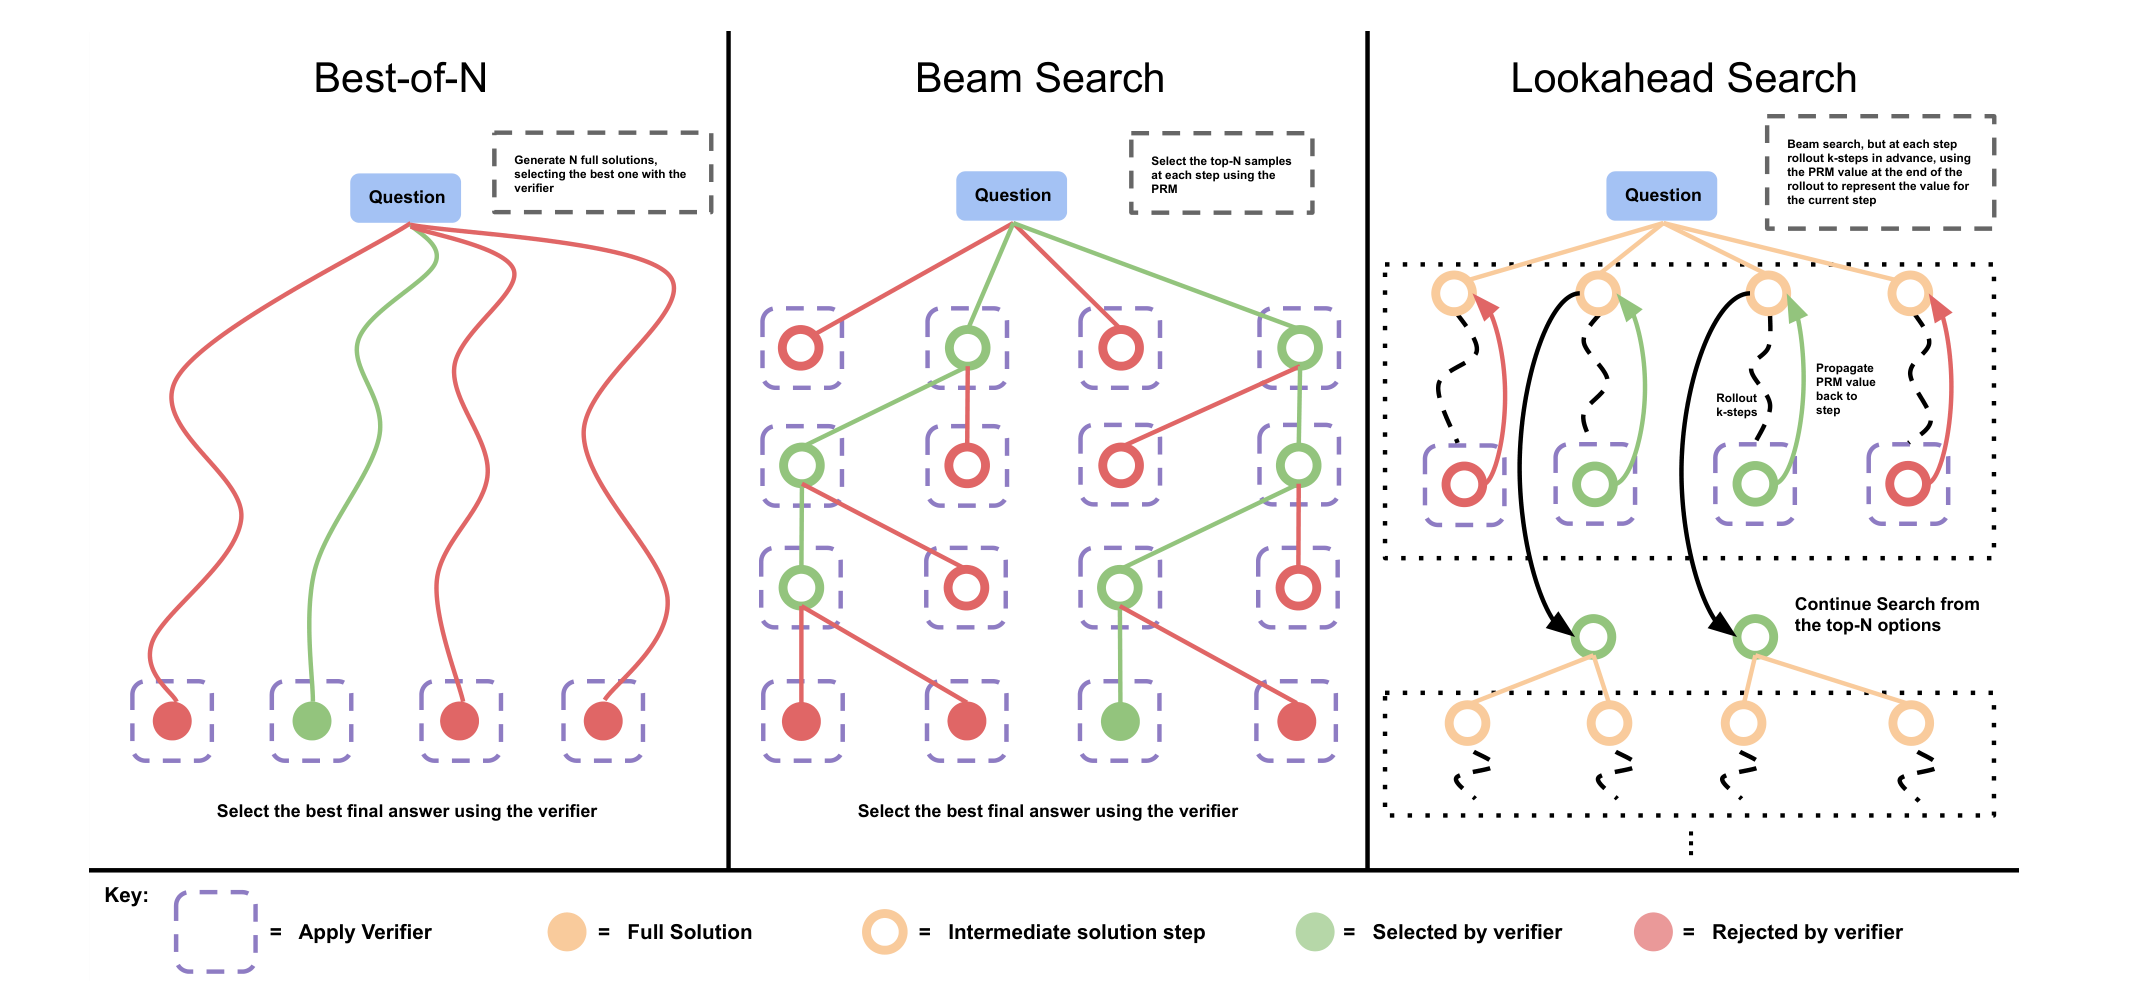

{'md_text': '![](./tmp/sample_pdf.pdf-7-1.png)',
 'img_path': './tmp/sample_pdf.pdf-7-1.png',
 'caption': 'The image compares three search algorithms: Best-of-N, Beam Search, and Lookahead Search. Best-of-N generates N full solutions and selects the best one using a verifier. Beam Search selects the top-N samples at each step using a PRM (Policy Representation Model). Lookahead Search is a beam search that rolls out k-steps in advance at each step, using the PRM value at the end of the rollout to represent the value for the current step. The image uses a key to define the elements of the diagrams: Apply Verifier, Full Solution, Intermediate solution step, Selected by verifier, and Rejected by verifier.'}

In [19]:
#Cross check
display(Image(filename='./tmp/sample_pdf.pdf-7-1.png'))#The user query should retrieve chunks which have description of this image
img_desc = [i for i in image_data if "sample_pdf.pdf-7-1.png" in i['img_path']][0]#Description of image
img_desc

In [20]:
#Check if the image description is in the passages which are retrieved
img_desc['caption'] in passages

True

## Conclusion

This notebook demonstrates how generative AI can be used to develop powerful RAG-based question-answering systems. With advancements like multimodal LLMs, we are no longer limited to text.

Challenges such as handling data in image format can now be addressed by generating detailed image descriptions and using them as placeholders. This significantly extends the capabilities of RAG systems.

Similar approach is observed in our case, where the user queries based on an image, and the top-k retrieved chunks include the description of that image. The final answer generated by Gemini incorporates that output.